# Exoplanet Detection
In this notebook, we will use data science techniques and machine learning to predict potential exoplanets in star systems using light intensity curves data derived from observations made by the NASA Kepler space telescope.

<img src="./images/image.jpg" width="400">

## Introduction

Exoplanets are planets located outside our solar system. These exoplanets are diverse in size and orbit where some are as large as giants closely orbiting their stars, while others are icy or rocky. 

A key focus of astronomical research is finding Earth-like exoplanets in habitable zones, areas around stars where conditions are just right for liquid water to exist. The search for exoplanets, planets beyond our solar system, is driven by questions about their existence, diversity, and the potential for life. 


### The Kepler Space Telescope
The Kepler mission marked a significant breakthrough in exoplanet discovery. Prior to Kepler, only a few exoplanets were known. Kepler, using the Transit method, dramatically increased this number by continuously monitoring star brightness.


### NASA's Transit Method

Unlike planets in our solar system that reflect sunlight, exoplanets are too distant and dim to be observed directly. Scientists at NASA use the Transit method to detect these distant worlds. 

This method involves observing stars for tiny dips in brightness, which occur when a planet crosses in front of a star. By analyzing these brightness changes, astronomers can deduce the existence, size, and orbit of exoplanets.

![Transit Method](./images/Transit.gif)

## Dataset Description

The [Keplar Dataset](https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data), publicly available from NASA, includes flux readings from over 3000 stars, each labeled as either housing an exoplanet or not. We will be analysing this data from the Kepler mission to identify potentially habitable exoplanets. Each star has a binary label of 2 or 1. 2 indicated that that the star is confirmed to have at least one exoplanet in orbit; some observations are in fact multi-planet systems.

As you can imagine, planets themselves do not emit light, but the stars that they orbit do. If said star is watched over several months or years, there may be a regular 'dimming' of the flux (the light intensity). This is evidence that there may be an orbiting body around the star; such a star could be considered to be a 'candidate' system. Further study of our candidate system, for example by a satellite that captures light at a different wavelength, could solidify the belief that the candidate can in fact be 'confirmed'.

<img src="./images/light-curves-star.png" width="600">

In the above diagram, a star is orbited by a planet. At `t = 2:30`, the starlight intensity drops because it is partially obscured by the planet, given our position. The starlight rises back to its original value at `t = 5:00`. The graph in each box shows the measured flux (light intensity) at each time interval.

## 1. Project Setup and Configuration

### 1.1 Importing Libraries

In [54]:
# Importing Libraries
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import ndimage
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import recall_score, precision_score, classification_report,accuracy_score,confusion_matrix, roc_curve, auc

In [55]:
# Configurations
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

### 1.2 Loading Dataset into Pandas DataFrame

In [56]:
exoplanet_data = pd.read_csv('./nasa exoplanet data.csv').fillna(0)
exoplanet_data

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,1,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,1,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,1,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,1,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


## 2. Exploratory Data Analysis

### 2.1 Initial Data Analysis and Feature Engineering

In [57]:
exoplanet_data.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [58]:
# Label Encoding of Target Feature
categ = {2: 1, 1: 0}
exoplanet_data.LABEL = [categ[item] for item in exoplanet_data.LABEL]

In [59]:
print("Dataset Shape: ", exoplanet_data.shape)

print("Dataset Description: ")
exoplanet_data.describe()

Dataset Shape:  (5087, 3198)
Dataset Description: 


,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
count,5087.000000,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,...,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5087.000000,5087.000000,5087.000000,5087.000000
mean,0.007273,1.445054e+02,1.285778e+02,1.471348e+02,1.561512e+02,1.561477e+02,1.469646e+02,1.168380e+02,1.144983e+02,1.228639e+02,...,3.485578e+02,4.956476e+02,6.711211e+02,7.468790e+02,6.937372e+02,6.553031e+02,-494.784966,-544.594264,-440.239100,-300.536399
std,0.084982,2.150669e+04,2.179717e+04,2.191309e+04,2.223366e+04,2.308448e+04,2.410567e+04,2.414109e+04,2.290691e+04,2.102681e+04,...,2.864786e+04,3.551876e+04,4.349963e+04,4.981375e+04,5.087103e+04,5.339979e+04,17844.469520,17722.339334,16273.406292,14459.795577
min,0.000000,-2.278563e+05,-3.154408e+05,-2.840018e+05,-2.340069e+05,-4.231956e+05,-5.975521e+05,-6.724046e+05,-5.790136e+05,-3.973882e+05,...,-3.240480e+05,-3.045540e+05,-2.933140e+05,-2.838420e+05,-3.288214e+05,-5.028894e+05,-775322.000000,-732006.000000,-700992.000000,-643170.000000
25%,0.000000,-4.234000e+01,-3.952000e+01,-3.850500e+01,-3.505000e+01,-3.195500e+01,-3.338000e+01,-2.813000e+01,-2.784000e+01,-2.683500e+01,...,-1.760000e+01,-1.948500e+01,-1.757000e+01,-2.076000e+01,-2.226000e+01,-2.440500e+01,-26.760000,-24.065000,-21.135000,-19.820000
50%,0.000000,-7.100000e-01,-8.900000e-01,-7.400000e-01,-4.000000e-01,-6.100000e-01,-1.030000e+00,-8.700000e-01,-6.600000e-01,-5.600000e-01,...,2.600000e+00,2.680000e+00,3.050000e+00,3.590000e+00,3.230000e+00,3.500000e+00,-0.680000,0.360000,0.900000,1.430000
75%,0.000000,4.825500e+01,4.428500e+01,4.232500e+01,3.976500e+01,3.975000e+01,3.514000e+01,3.406000e+01,3.170000e+01,3.045500e+01,...,2.211000e+01,2.235000e+01,2.639500e+01,2.909000e+01,2.780000e+01,3.085500e+01,18.175000,18.770000,19.465000,20.280000
max,1.000000,1.439240e+06,1.453319e+06,1.468429e+06,1.495750e+06,1.510937e+06,1.508152e+06,1.465743e+06,1.416827e+06,1.342888e+06,...,1.779338e+06,2.379227e+06,2.992070e+06,3.434973e+06,3.481220e+06,3.616292e+06,288607.500000,215972.000000,207590.000000,211302.000000


In [60]:
exoplanet_data.isnull().sum()

LABEL        0
FLUX.1       0
FLUX.2       0
FLUX.3       0
FLUX.4       0
            ..
FLUX.3193    0
FLUX.3194    0
FLUX.3195    0
FLUX.3196    0
FLUX.3197    0
Length: 3198, dtype: int64

<div class="alert alert-block alert-info">Initial Reading Analysis: Everything appears to be in order at this stage. Our label values are neatly categorized as 0 and 1, and there are no null values to contend with.</div> 

### 2.2 Geting an idea about the Class Distribution

LABEL
0    5050
1      37
Name: count, dtype: int64


Text(0.5, 0.98, '0: Not Exoplanet; 1: Exoplanet\n')

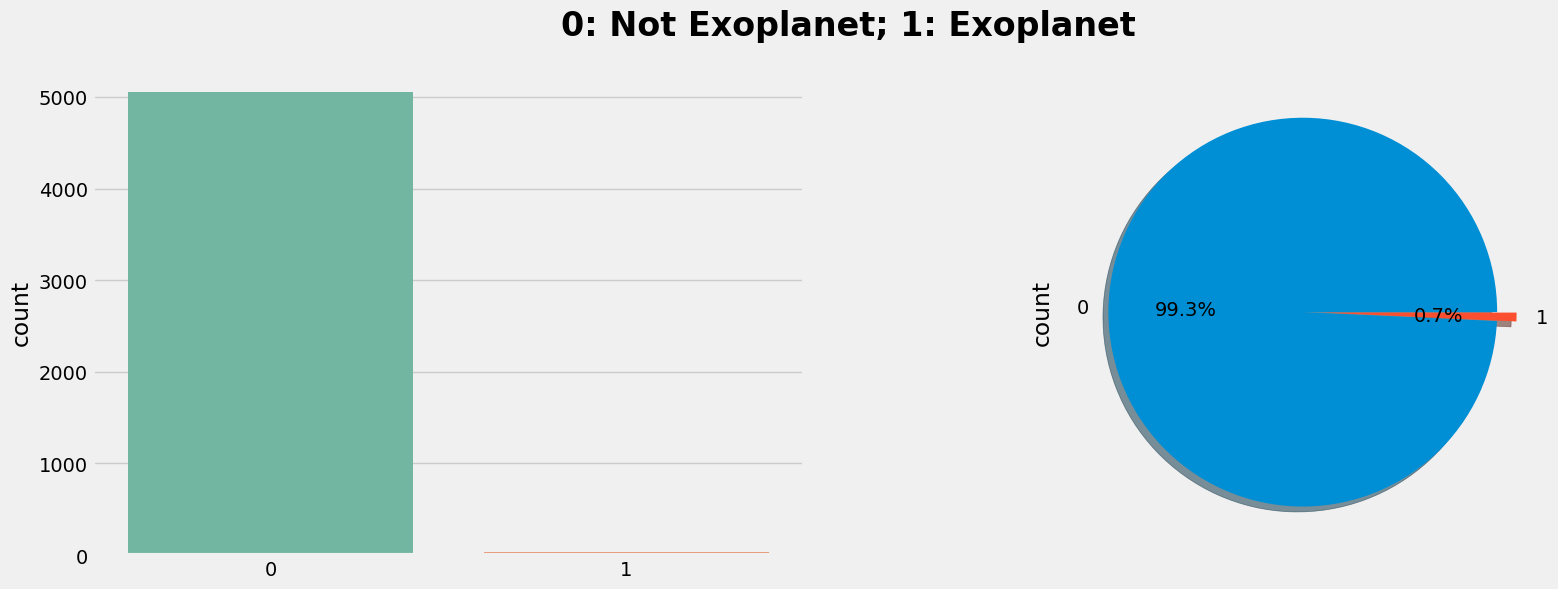

In [61]:
print(exoplanet_data['LABEL'].value_counts())

fig, ax = plt.subplots(1, 2, figsize=(18,6))
sns.countplot(x = 'LABEL', data=exoplanet_data, palette = "Set2", ax = ax[0])
ax[0].set_xlabel('')
exoplanet_data['LABEL'].value_counts().plot.pie(explode = [0,0.1], autopct ='%1.1f%%',ax = ax[1], shadow = True)
fig.suptitle('0: Not Exoplanet; 1: Exoplanet\n', fontsize = 24, fontweight = 'bold')

<div class="alert alert-block alert-danger">Huge disproportion in the data: 99.3% not exoplanet while only 0.7% is an exoplanet.</div>

### 2.3 Correlation in the data

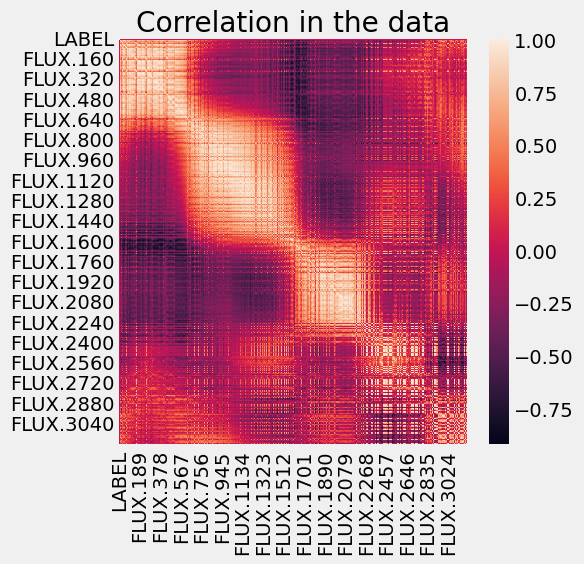

In [62]:
plt.figure(figsize=(5,5))
sns.heatmap(exoplanet_data.corr())
plt.title('Correlation in the data')
plt.show()

<div class="alert alert-block alert-warning">Analysis: The correlation matrix doesn't provide much insight in this case. Since all the variables are fluxes, they represent independent measurements.</div>

### 2.4 Investigating Flux

In [63]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

train_y=exoplanet_data[exoplanet_data['LABEL'] == 1]
train_n=exoplanet_data[exoplanet_data['LABEL'] < 1]
train_t_n=train_n.iloc[:,1:].T
train_t_y=train_y.iloc[:,1:].T
train_t_y.head(1)

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
FLUX.1,93.85,-38.88,532.64,326.52,-1107.21,211.1,9.34,238.77,-103.54,-265.91,...,124.39,-63.5,31.29,-472.5,194.82,26.96,43.07,-248.23,22.82,26.24


In [64]:
# Flux Variations of Non Exoplanets Stars
fig = make_subplots(rows=2, cols=2,subplot_titles=("Flux variation of star 37", "Flux variation of star 5086", 
                                                   "Flux variation of star 3000", "Flux variation of star 3001"))
fig.add_trace(
    go.Scatter(y=train_t_n[37], x=train_t_n.index),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(y=train_t_n[5086], x=train_t_n.index),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(y=train_t_n[3000], x=train_t_n.index),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(y=train_t_n[3001], x=train_t_n.index),
    row=2, col=2
)
fig.update_layout(height=600, width=800, title_text="Flux Variations of Non Exoplanets Stars",showlegend=False)
fig.show()

In [65]:
# Flux Variations of Exoplanets Stars
fig = make_subplots(rows=2, cols=2,subplot_titles=("Flux variation of star 0", "Flux variation of star 1", 
                                                   "Flux variation of star 35", "Flux variation of star 36"))
fig.add_trace(
    go.Scatter(y=train_t_y[0], x=train_t_y.index),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(y=train_t_y[1], x=train_t_y.index),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(y=train_t_y[35], x=train_t_y.index),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(y=train_t_y[36], x=train_t_y.index),
    row=2, col=2
)
fig.update_layout(height=600, width=800, title_text="Flux Variations of Exoplanets Stars",showlegend=False)

<div class="alert alert-block alert-success">We see clear periodic motion: We still see clear anomalies from detection error, but there is periodic motion evident in all the plots. Even star 35 shows periodic motion, albeit on a smaller amplitude. This is due to the fact that there is a planet orbiting in front of the star periodically, therefore decreasing the flux received. </div>

## 3. Data Preprocessing

### 3.1 Handling Missing Values

<Axes: >

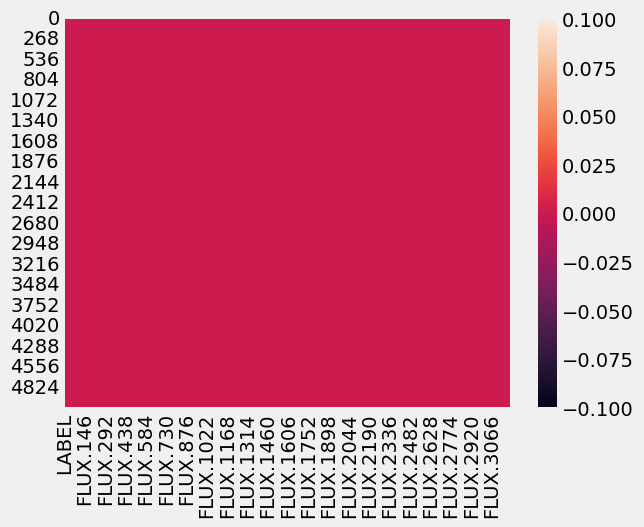

In [66]:
sns.heatmap(exoplanet_data.isnull())

<div class="alert alert-block alert-info">We can see from the heat map that we dont have any missing values in our dataset.</div>

### 3.2 Outlier Detection and Removal

<Axes: xlabel='LABEL', ylabel='FLUX.5'>

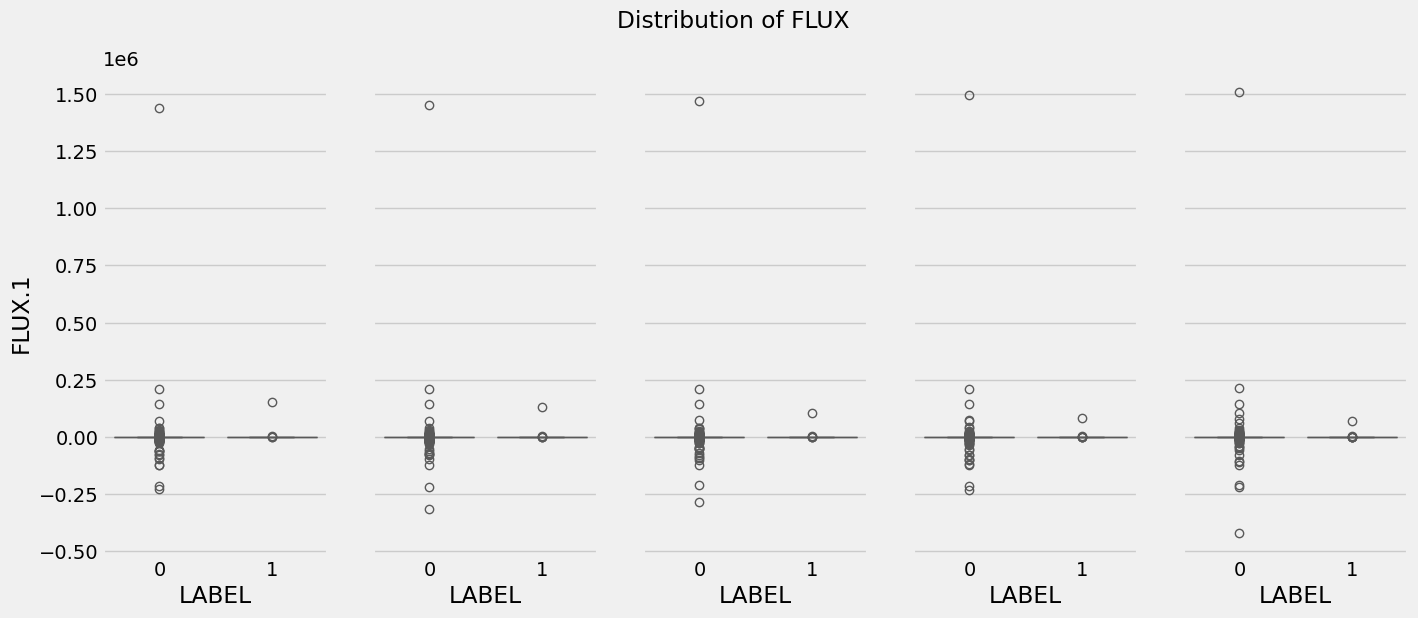

In [67]:
fig, axes = plt.subplots(1, 5,figsize=(15, 6), sharey=True)
fig.suptitle('Distribution of FLUX')

sns.boxplot(ax=axes[0], data=exoplanet_data, x='LABEL', y='FLUX.1',palette="Set2")
sns.boxplot(ax=axes[1], data=exoplanet_data, x='LABEL', y='FLUX.2',palette="Set2")
sns.boxplot(ax=axes[2], data=exoplanet_data, x='LABEL', y='FLUX.3',palette="Set2")
sns.boxplot(ax=axes[3], data=exoplanet_data, x='LABEL', y='FLUX.4',palette="Set2")
sns.boxplot(ax=axes[4], data=exoplanet_data, x='LABEL', y='FLUX.5',palette="Set2")

In [68]:
exoplanet_data.drop(exoplanet_data[exoplanet_data['FLUX.1']>250000].index, axis=0, inplace=True)

### 3.3 Handling Imbalance using SMOTE (Synthetic Minority Oversampling Technique)

In [69]:
from imblearn.over_sampling import SMOTE
model = SMOTE()
input_features, output_feature = model.fit_resample(exoplanet_data.drop('LABEL',axis=1), exoplanet_data['LABEL'])
output_feature = output_feature.astype('int')

In [70]:
output_feature.value_counts()

LABEL
1    5049
0    5049
Name: count, dtype: int64

### 3.4 Data Normalization

**Data Normalization** is a technique often applied as part of data preparation for machine learning. The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values.

In [71]:
input_features = normalized = normalize(input_features)

### 3.5 Apply Gaussian Filters

In probability theory, the normal (or Gaussian or Gauss or Laplace–Gauss) distribution is a very common continuous probability distribution. Normal distributions are important in statistics and are often used in the natural and social sciences to represent real-valued random variables whose distributions are not known.

In [72]:
input_features = filtered = ndimage.filters.gaussian_filter(input_features, sigma=10)

### 3.6 Feature Scaling

We will use feature scaling so that all the values remain in the comparable range.

In [73]:
std_scaler = StandardScaler()
input_features = scaled = std_scaler.fit_transform(input_features)

### 3.7 Dimensionality Reduction using PCA (Principal Component Analysis)

In [74]:
from sklearn.decomposition import PCA
pca = PCA() 
input_features = pca.fit_transform(input_features)
input_features = pca.transform(input_features)
total=sum(pca.explained_variance_)
k=0
current_variance=0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k=k+1
print(k)

23


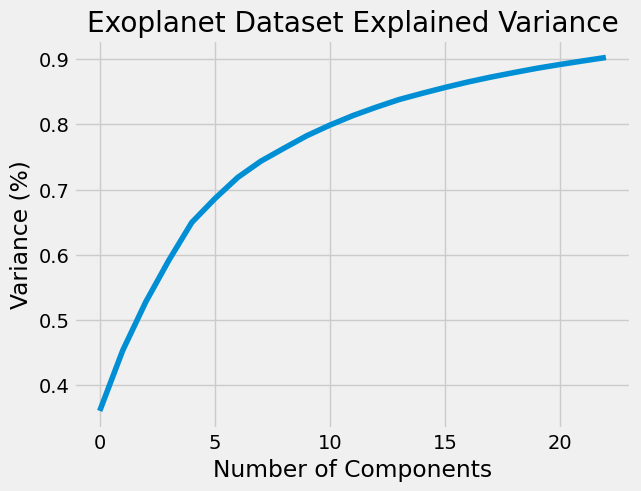

In [75]:
pca = PCA(n_components=23)
input_features = pca.fit_transform(input_features)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.title('Exoplanet Dataset Explained Variance')
plt.show()

In [76]:
input_features.shape

(10098, 23)

### 3.8 Splitting into Testing Data and Training Data

In [77]:
train_X, test_X, train_y, test_y = train_test_split(input_features, output_feature, test_size=0.33, random_state=42)

## 4. Model Building and Evaluation

In this section, we will build and evaluate several machine learning models. We will start with traditional models and proceed to more advanced models. The performance of these models will be assessed based on their accuracy, precision, recall, and F1-score.

### Model Building

In [78]:
def model(classifier,dtrain_x,dtrain_y,dtest_x,dtest_y):
    classifier.fit(dtrain_x,dtrain_y)

    prediction=classifier.predict(dtest_x)

    print('Validation accuracy of model is', accuracy_score(prediction,dtest_y))
    print ("\nClassification report :\n",(classification_report(dtest_y,prediction)))

    #Confusion matrix
    plt.figure(figsize=(13,10))
    plt.subplot(221)
    sns.heatmap(confusion_matrix(dtest_y,prediction),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
    plt.title("CONFUSION MATRIX",fontsize=20)

    #ROC curve and Area under the curve plotting
    predicting_probabilites = classifier.predict_proba(dtest_x)[:,1]
    fpr,tpr,thresholds = roc_curve(dtest_y,predicting_probabilites)
    plt.subplot(222)
    plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
    plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
    plt.legend(loc = "best")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

### 4.1 K Nearest Neighbors

Validation accuracy of model is 0.9993999399939995

Classification report :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1709
           1       1.00      1.00      1.00      1624

    accuracy                           1.00      3333
   macro avg       1.00      1.00      1.00      3333
weighted avg       1.00      1.00      1.00      3333



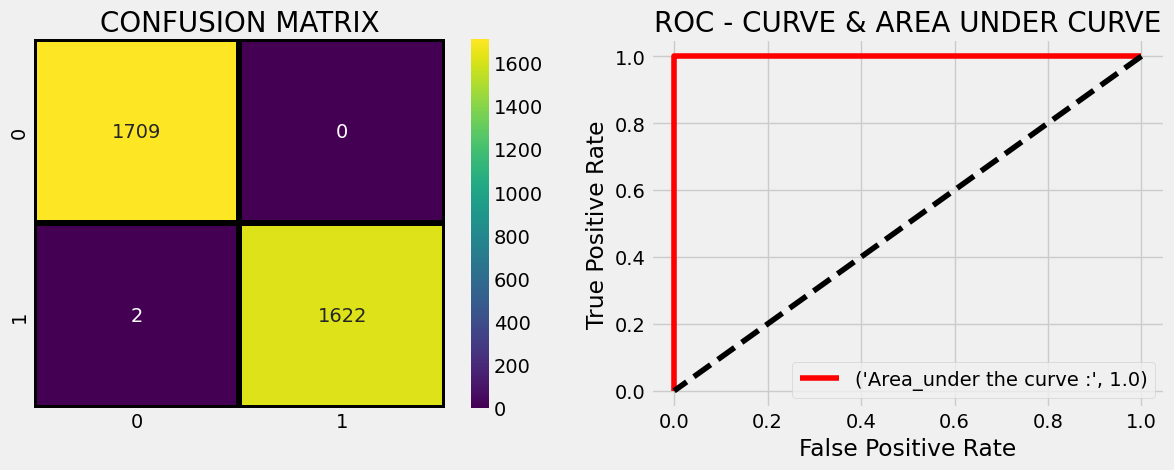

In [79]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()
model(knn_model,train_X,train_y,test_X,test_y)

### 4.2 Logistic Regression

Validation accuracy of model is 0.9996999699969997

Classification report :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1709
           1       1.00      1.00      1.00      1624

    accuracy                           1.00      3333
   macro avg       1.00      1.00      1.00      3333
weighted avg       1.00      1.00      1.00      3333



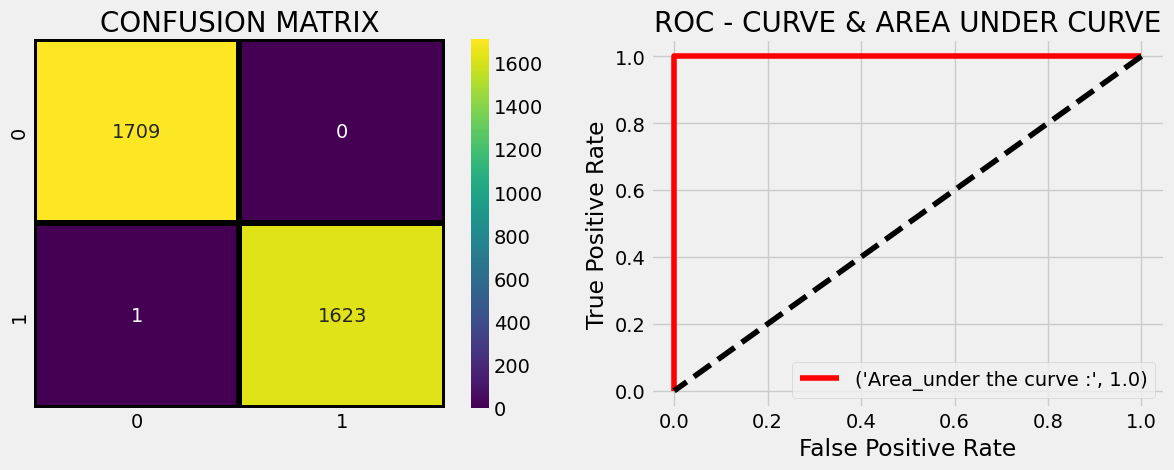

In [80]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(solver='lbfgs', max_iter=1000)
model(lr_model,train_X,train_y,test_X,test_y)

### 4.3 Bernoulli Naive Bayes

Validation accuracy of model is 0.9996999699969997

Classification report :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1709
           1       1.00      1.00      1.00      1624

    accuracy                           1.00      3333
   macro avg       1.00      1.00      1.00      3333
weighted avg       1.00      1.00      1.00      3333



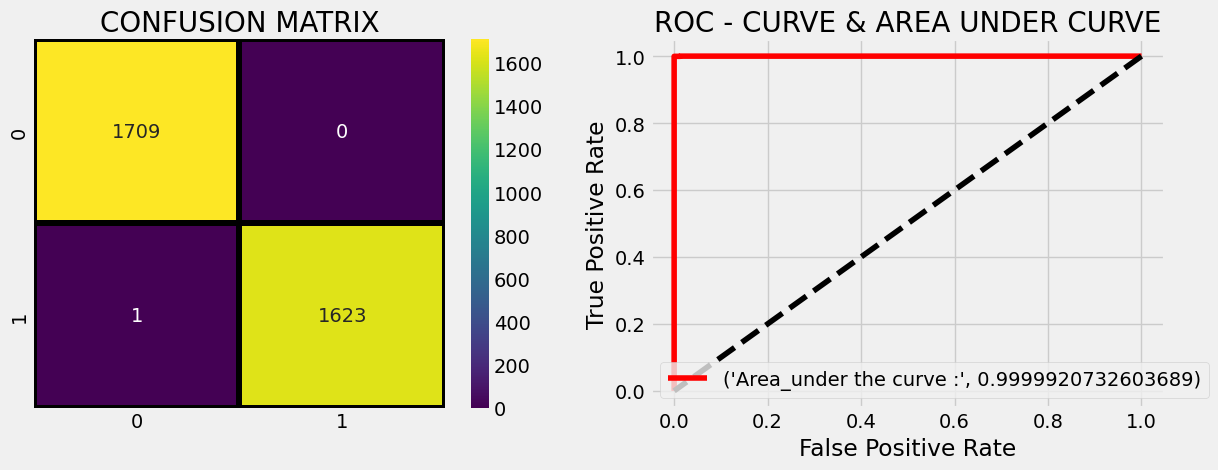

In [81]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
model(bnb,train_X,train_y,test_X,test_y)

### 4.4 Decision Tree Algorithm

Validation accuracy of model is 0.9996999699969997

Classification report :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1709
           1       1.00      1.00      1.00      1624

    accuracy                           1.00      3333
   macro avg       1.00      1.00      1.00      3333
weighted avg       1.00      1.00      1.00      3333



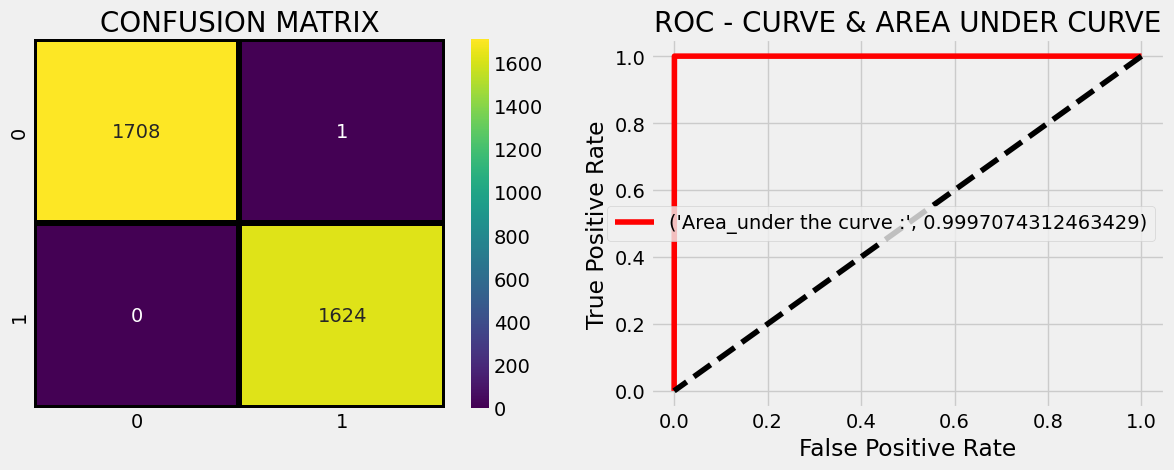

In [82]:
from sklearn.tree import DecisionTreeClassifier
ds_model = DecisionTreeClassifier(max_depth=5, random_state=13)
model(ds_model,train_X,train_y,test_X,test_y)

### 4.5 Random Forest Algorithm

Validation accuracy of model is 1.0

Classification report :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1709
           1       1.00      1.00      1.00      1624

    accuracy                           1.00      3333
   macro avg       1.00      1.00      1.00      3333
weighted avg       1.00      1.00      1.00      3333



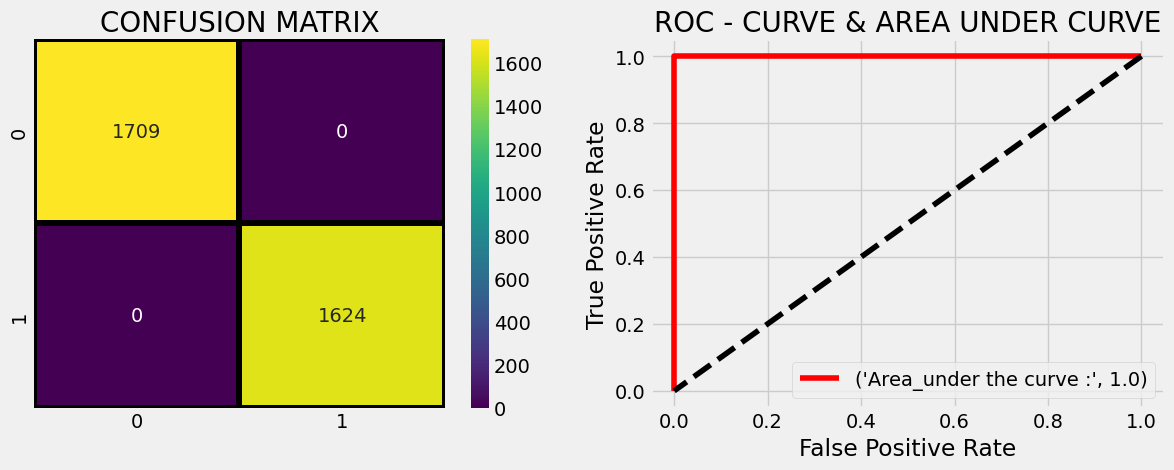

In [83]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier()
model(rf_classifier,train_X,train_y,test_X,test_y)

### 4.6 XGBoost Classifier

Validation accuracy of model is 0.9996999699969997

Classification report :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1709
           1       1.00      1.00      1.00      1624

    accuracy                           1.00      3333
   macro avg       1.00      1.00      1.00      3333
weighted avg       1.00      1.00      1.00      3333



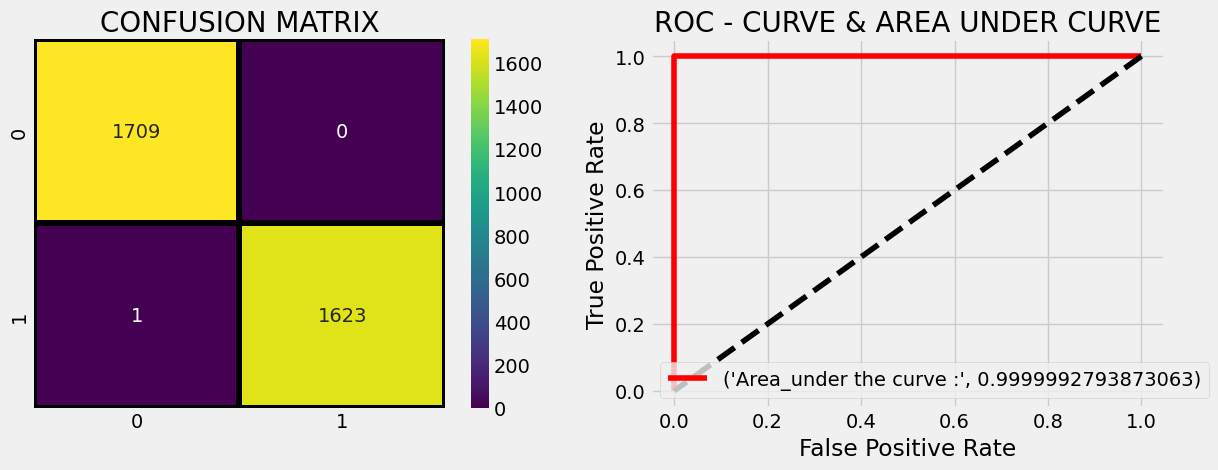

In [84]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
model(xgb,train_X,train_y,test_X,test_y)

### 4.7 Artificial Neural Network

In [85]:
from keras.models import Sequential
from keras.layers import Dense

# Building Neural Network Model
nn = Sequential()
nn.add(Dense(64, activation='relu', input_shape=(train_X.shape[1],)))
nn.add(Dense(32, activation='relu'))
nn.add(Dense(1, activation='sigmoid'))

nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn.fit(train_X, train_y, epochs=10, batch_size=32)

nn_predictions = nn.predict(test_X) > 0.5

Epoch 1/10
212/212 [==============================] - 5s 13ms/step - loss: 0.1143 - accuracy: 0.9842
Epoch 2/10
212/212 [==============================] - 2s 7ms/step - loss: 3.1381e-04 - accuracy: 0.9999
Epoch 3/10
212/212 [==============================] - 1s 7ms/step - loss: 3.1022e-04 - accuracy: 0.9999
Epoch 4/10
212/212 [==============================] - 1s 7ms/step - loss: 6.5874e-04 - accuracy: 0.9997
Epoch 5/10
212/212 [==============================] - 1s 7ms/step - loss: 9.7639e-04 - accuracy: 0.9996
Epoch 6/10
212/212 [==============================] - 1s 7ms/step - loss: 0.0014 - accuracy: 0.9994
Epoch 7/10
212/212 [==============================] - 1s 7ms/step - loss: 3.4945e-04 - accuracy: 0.9999
Epoch 8/10
212/212 [==============================] - 1s 7ms/step - loss: 2.0007e-04 - accuracy: 0.9999
Epoch 9/10
212/212 [==============================] - 1s 7ms/step - loss: 1.9781e-04 - accuracy: 1.0000
Epoch 10/10
105/105 [==============================] - 0s 2ms/step


Validation accuracy of model is 0.9993999399939995

Classification report :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1709
           1       1.00      1.00      1.00      1624

    accuracy                           1.00      3333
   macro avg       1.00      1.00      1.00      3333
weighted avg       1.00      1.00      1.00      3333



Text(0.5, 1.0, 'CONFUSION MATRIX')

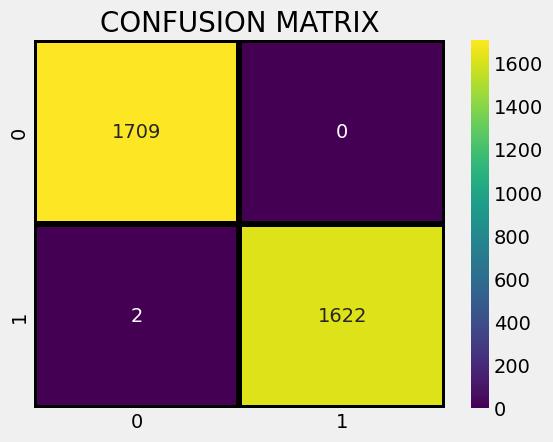

In [86]:
print('Validation accuracy of model is', accuracy_score(nn_predictions,test_y))
print ("\nClassification report :\n",(classification_report(test_y,nn_predictions)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(test_y,nn_predictions),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

## 5. Model Analysis and Conclusion

1. K Nearest Neighbors
```
    Validation accuracy of model is 0.9993999399939995
```

2. Logistic Regression
```
    Validation accuracy of model is 1.0
```

3. Bernaulli Naive Bayes
```
    Validation accuracy of model is 0.9948994899489949
```

4. Decision Tree Algorithm
```
    Validation accuracy of model is 0.9996999699969997
```

5. Random Forest Algorithm
```
    Validation accuracy of model is 0.9996999699969997
```

6. XGBoost Classifier
```
    Validation accuracy of model is 0.9996999699969997
```

7. Artificial Neural Network
```
    Validation accuracy of model is 0.9996999699969997
```

<div class="alert alert-block alert-info">In conclusion, this project demonstrated the application of various machine learning models to the task of exoplanet detection using data from the Kepler Space Telescope. 

This study also highlights the potential and challenges of machine learning in astronomical data analysis. Future work could explore more complex models, feature engineering techniques, and larger datasets to further enhance the detection of exoplanets.</div>